In [3]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

In [4]:
# import datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

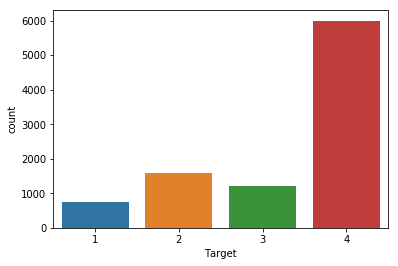

In [5]:
# extract target variable from train set
target = train['Target']
del train['Target']

# view the distribution of the target variable
sns.countplot(target) # target variable has imbalanced classes; use balanced class weights when building random forest later

# extract Id variable from test set
Id = test['Id']

In [6]:
# bind the rows of the train and test sets
full = pd.concat([train,test], axis='rows')

# drop unwanted variables
full.drop(columns=['Id','idhogar','parentesco1'], inplace=True)

In [7]:
# check for missing values
full.isnull().any().describe()

count       139
unique        2
top       False
freq        134
dtype: object

In [8]:
# create list of numeric variables with missing values
numeric_cols_with_missing = [] # initialize empty list

for col, col_data in full.iteritems():
    if col_data.isnull().any() and (col_data.dtype=='int' or col_data.dtype=='float'):
        numeric_cols_with_missing.append(col)

# impute numeric variables' missing values with variable medians
for var in numeric_cols_with_missing:
    full[var].fillna(full[var].median(), inplace = True)

# create list of object variables with missing values
object_cols_with_missing = []

for col, col_data in full.iteritems():
    if col_data.isnull().any() and col_data.dtype=='object':
        object_cols_with_missing.append(col)

# impute object variables' missing values with variable modes
for var in object_cols_with_missing:
    full[var].fillna(full[var].mode()[0], inplace = True)

# confirm that there are no more missing values
full.isnull().any().describe()

count       139
unique        1
top       False
freq        139
dtype: object

In [9]:
# view string variables
object_cols = []

for col, col_data in full.iteritems():
    if col_data.dtype=='object':
        object_cols.append(col)

for object_col in object_cols:
    print(full[object_col].value_counts())
    print('-'*50)

# dependency is not needed because we have SQBdependency. edjefa and edjefe are not needed because they are interactions of existing numeric variables (and random forest can capture interactions)
full.drop(columns=object_cols, inplace=True)

yes          7580
no           6036
.5           5175
2            2499
1.5          2471
.33333334    2131
.66666669    1617
8            1415
.25           944
3             832
1.3333334     362
.2            306
.75           301
2.5           301
4             295
.40000001     259
.60000002     136
1.6666666     128
5             120
1.25           72
.80000001      63
.16666667      63
3.5            36
.83333331      33
.14285715      32
2.3333333      30
2.25           26
1.2            22
.2857143       18
7              16
6              14
.85714287      13
3.3333333      13
.71428573      12
.375           11
1.75           11
.22222222      11
.125            9
Name: dependency, dtype: int64
--------------------------------------------------
no     12818
6       6958
11      2507
9       1564
3       1046
8       1020
15       910
14       804
7        797
17       702
5        685
2        617
16       609
4        505
12       494
yes      416
10       395
13       341


In [10]:
# confirm that there are no more string variables
print(full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33413 entries, 0 to 23855
Columns: 136 entries, v2a1 to agesq
dtypes: float64(8), int64(128)
memory usage: 34.9 MB
None


In [11]:
# feature engineering
full['mean_overcrowding'] = full[['hacdor','hacapo']].mean(axis=1)

full['under12_12andover'] = full['r4t1'] / full['r4t2']

In [12]:
# split full dataset into train and test sets
train = full[:train.shape[0]]
test = full[train.shape[0]:]

In [13]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# initialize a template for random forest, based on the parameters you want to set
rfc = RandomForestClassifier(n_jobs=-1,
                             n_estimators=200,
                             max_depth=7,
                             class_weight='balanced')

# perform cross-validation
rfc_cv = model_selection.cross_validate(rfc,
                                        train,
                                        target,
                                        scoring='f1_macro',
                                        cv=10)

print('the mean training macro F1 score is:', rfc_cv['train_score'].mean())
print('the mean cross-validation macro F1 score is:', rfc_cv['test_score'].mean())

the mean training macro F1 score is: 0.6923052444357652
the mean cross-validation macro F1 score is: 0.3866302649583043


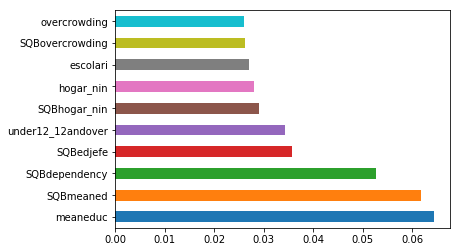

In [14]:
# fit the random forest
rfc_fitted = rfc.fit(train,target)

# plot feature importance (as determined by the built random forest model)
feature_importances = pd.Series(rfc_fitted.feature_importances_, index=train.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance
feature_importances.nlargest(10).plot(kind='barh') # seems like elevation is by far the most useful predictor

In [15]:
# generate predictions for the test set
predictions_rfc = rfc_fitted.predict(test)
predictions_rfc = predictions_rfc.astype('int')

submission_rfc = pd.DataFrame({'Id': Id,
                               'Target': predictions_rfc})
submission_rfc.to_csv("submission1.csv", index=False)